# 0 Import of used packages

In [2]:
# Import used packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set(style="whitegrid", context="paper", font_scale=1.5, font = "Times New Roman")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

#01 Import of dataset, data exploration and preparation

In [4]:
# Set filepath and import raw data
file_path = "/content/drive/MyDrive/Bachelorarbeit/Insurance Data (positive data - Gamma Regression)/Dataset/insurance.csv"
insurance_data_raw = pd.read_csv(file_path)

print(insurance_data_raw.shape)

(1338, 7)


## 1.1 Data Preparation

In [5]:
# Create copy of raw data
insurance_data = insurance_data_raw.copy()
insurance_data.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
#Check for missing data
insurance_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
# Check for duplicate rows
duplicate_rows_df = insurance_data[insurance_data.duplicated()]
print("number of duplicate rows:", duplicate_rows_df.shape)

number of duplicate rows: (1, 7)


In [8]:
# Dropping duplicate values
insurance_data = insurance_data.drop_duplicates()

In [9]:
# Perform One-Hot encoding for categorical features
insurance_data = pd.get_dummies(insurance_data)
insurance_data.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [10]:
# Add indicator for obesity to dataset (bmi > 30)
insurance_data["bmi30"] = (insurance_data['bmi'] > 30).astype(int)
insurance_data.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,bmi30
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1,0
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0,1
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0,1
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0,0


In [11]:
# Ensure that all avalues are corretly formatted
insurance_data_final = insurance_data[insurance_data.columns].astype(float)

# Check variavle descriptions for anomalies
insurance_data_final.describe()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,bmi30
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487,0.495138,0.504862,0.795064,0.204936,0.242334,0.242334,0.272251,0.243082,0.526552
std,14.044333,6.100468,1.205571,12110.359656,0.500163,0.500163,0.403806,0.403806,0.428655,0.428655,0.445285,0.429104,0.499481
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.290000,0.000000,4746.344000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9386.161300,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,51.000000,34.700000,2.000000,16657.717450,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.2 Data Exploration

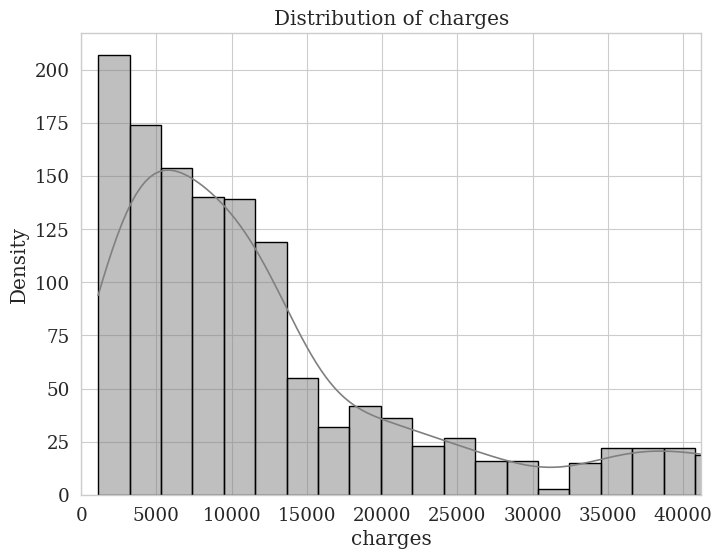

In [12]:
# Initialize pyplot figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# Create density plot and histogram for charges
sns.histplot(data=insurance_data_final, x='charges', kde=True,
             bins = 30, color='gray', edgecolor='black',
             linewidth=1, ax=ax)

# Adding grid lines
ax.grid(True)

# Customizing axes and title
ax.set_title('Distribution of charges')
ax.set_xlabel('charges')
ax.set_ylabel('Density')

# Restrict x-axis to range of charges
# Plot 95th percentile for better readability
max_cost = insurance_data_final['charges'].quantile(0.95)  # 95th percentile
ax.set_xlim(0, max_cost)

# Show plot
plt.show()



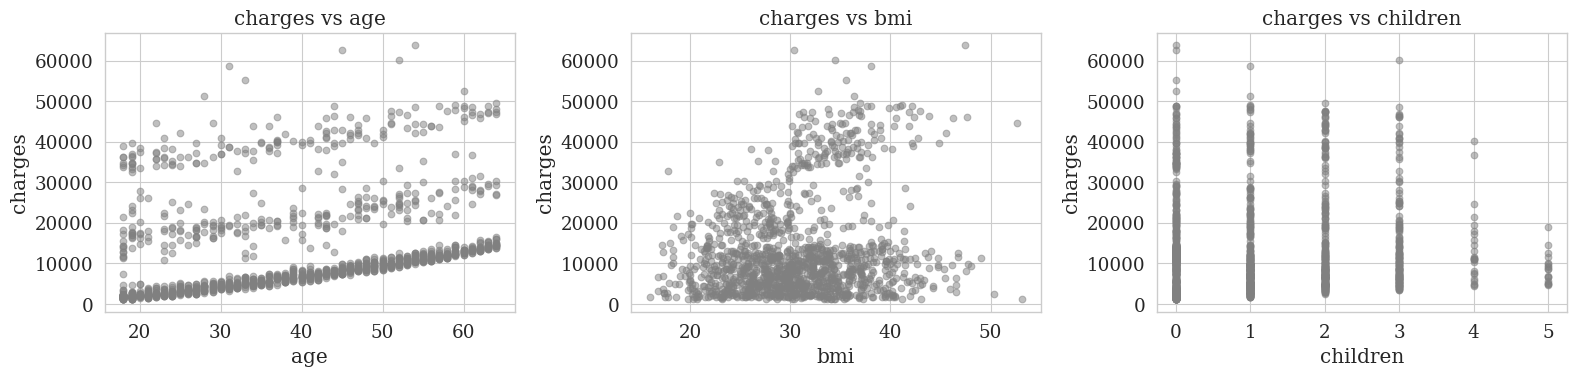

In [13]:
# Create array for target and predictors
target = 'charges'
predictors = ['age', 'bmi', 'children']

# Create a grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs = axs.flatten()

# Create a scatter plot for each predictor
for i, predictor in enumerate(predictors):
    axs[i].scatter(insurance_data_final[predictor], insurance_data_final[target], alpha=0.5, color = "gray")
    axs[i].set_title(f'{target} vs {predictor}')
    axs[i].set_xlabel(predictor)
    axs[i].set_ylabel(target)

# Adjust layout for better spacing
plt.tight_layout()

plt.show()

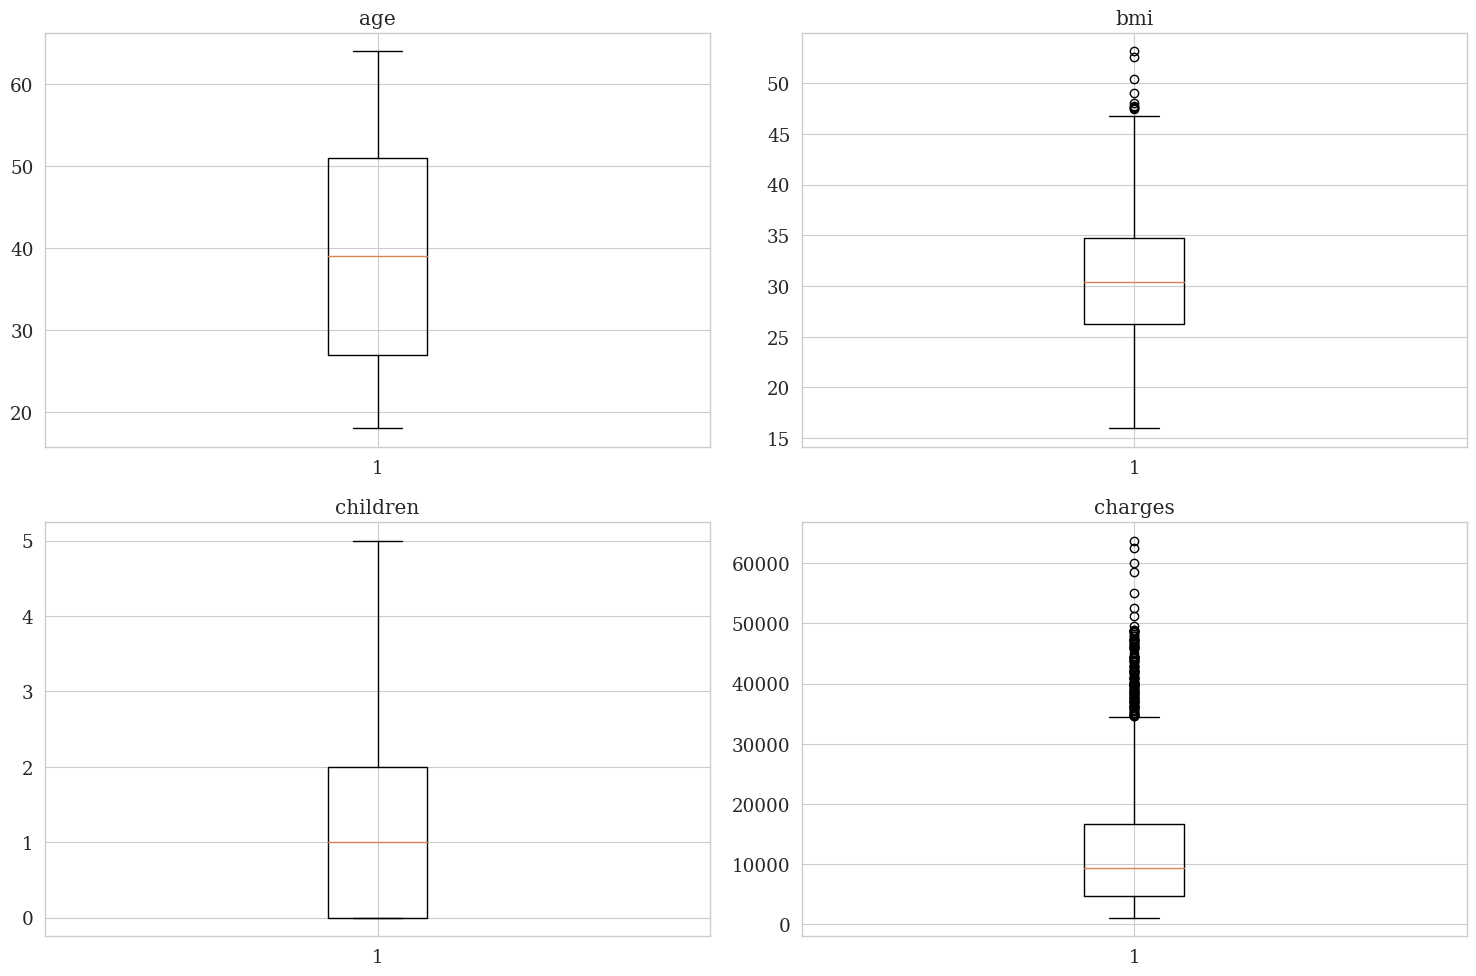

In [14]:
predictors = ['age', 'bmi', 'children', 'charges']

data_for_plot = insurance_data_final[predictors]

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 5 * 2)) # Adjust figure size as needed
axs = axs.flatten()  # Flatten the array of axes

# Plotting boxplots for each column
for i, column in enumerate(data_for_plot.columns):
    axs[i].boxplot(data_for_plot[column])
    axs[i].set_title(column)

# Hide any unused subplots
for i in range(4, 2 * 2):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

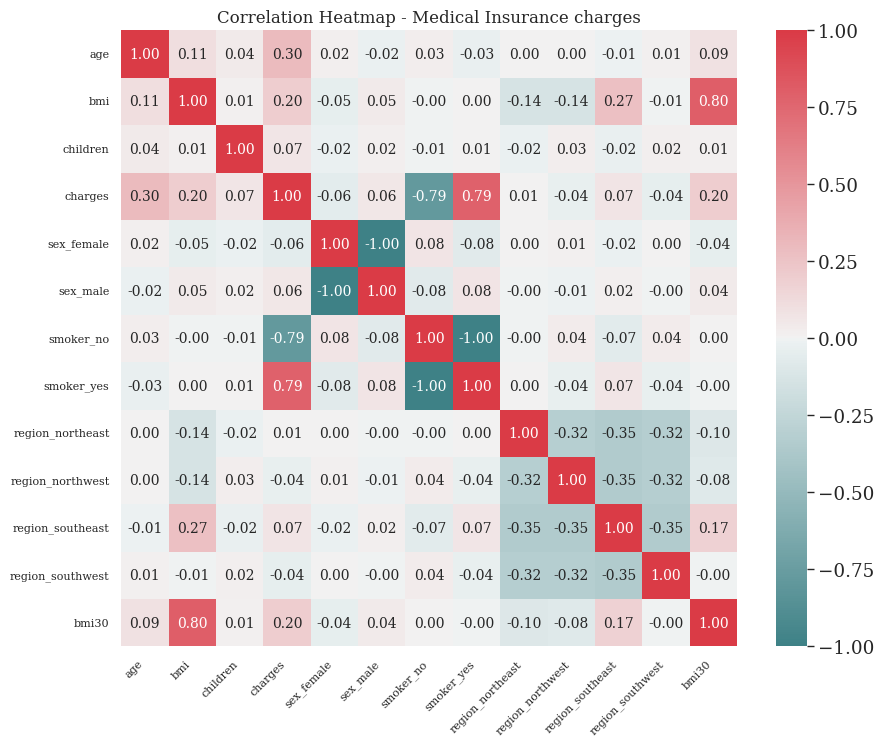

In [15]:
# Assuming 'insurance_data_final' is your DataFrame
correlation_df = insurance_data_final.corr()

# Initialize the matplotlib figure
fig, axs = plt.subplots(figsize=(10, 8))

# Generate heatmap using sns.heatmap-function
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap=sns.diverging_palette(200, 10, as_cmap=True),
            square=True, ax=axs, annot_kws={"size": 10})

# Adjust the plot for readability
# Adjust the plot for readability
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.yticks(rotation=0, fontsize = 8)
plt.title('Correlation Heatmap - Medical Insurance charges', fontsize = 12)

# Show the plot
plt.show()

## 1.3 Create and visualize training and test-dataset

In [16]:
def plot_train_test_split(df, test_size=0.3, max_samples=30):
    """
    Visualize a random train-test split using horizontal bars for limited number of indices.

    :param df: DataFrame, the entire dataset including features and the target variable.
    :param target_column_name: str, the name of the target variable column.
    :param test_size: float, represents the proportion of the dataset to include in the test split.
    :param max_samples: int, the maximum number of samples to visualize.
    """

    # Perform the random split
    train_set, test_set = train_test_split(df, test_size=test_size, random_state=1, shuffle=True)

    # Create an array of indices for plotting
    indices = np.arange(max_samples)

    # Create a figure
    plt.figure(figsize=(10, 3))

    # Initialize the bar heights
    train_bar_heights = np.zeros(max_samples)
    test_bar_heights = np.zeros(max_samples)

    # Set the heights for the training indices
    train_indices = train_set.index.intersection(indices)
    train_bar_heights[train_indices] = 0.5

    # Set the heights for the test indices
    test_indices = test_set.index.intersection(indices)
    test_bar_heights[test_indices] = 0.5

    # Plot training and test bars
    plt.bar(indices, train_bar_heights, color='gray', label='Training set', edgecolor='k')
    plt.bar(indices, test_bar_heights, color='white', label='Test set', edgecolor='k')

    # Adding labels and title
    plt.xlabel('Sample index')
    plt.xticks(indices)
    plt.yticks([])
    plt.title('Random Train-Test Split Visualization (First 30 Samples)')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

    return train_set, test_set

# 02 Modelling, Cross Validation and Prediction - GLM



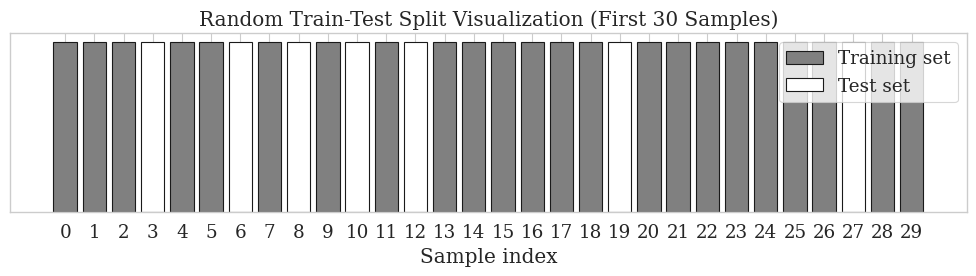

((935, 12), (402, 12), (935,), (402,))

In [51]:
# Call the function and create seperate training and test set
train_set, test_set = plot_train_test_split(insurance_data_final, test_size=0.3, max_samples=30)

# Reset indeces of training and test set
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Create target and feature vector for training set
X_train = train_set.drop(["charges"], axis = 1)
y_train = train_set["charges"]

# Create target and feature vector for test set
X_test = test_set.drop(["charges"], axis = 1)
y_test = test_set["charges"]

# Display the dimensions of the train and test sets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [52]:
# Add constant to feature vector of training set. This will serve as intercept later
X_train = sm.add_constant(X_train)

# Create Gamma model with log-link function and fit to training data
# As bmi30 is a feature that is later introduced as an improvement, this will be excluded for now
gamma_model1 = sm.GLM(y_train, X_train.drop(["bmi30", "smoker_yes", "sex_female"], axis = 1), family=sm.families.Gamma(link=sm.families.links.Log()))
gamma_results_1 = gamma_model1.fit()

# Print summary of Gamma model
print(gamma_results_1.summary2())

                Results: Generalized linear model
Model:                GLM              AIC:            18664.2575
Link Function:        Log              BIC:            -6094.9351
Dependent Variable:   charges          Log-Likelihood: -9323.1   
Date:                 2024-02-11 14:15 LL-Null:        -9870.6   
No. Observations:     935              Deviance:       239.41    
Df Model:             8                Pearson chi2:   419.      
Df Residuals:         926              Scale:          0.45269   
Method:               IRLS                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const             6.9823   0.1100  63.4577 0.0000  6.7666  7.1980
age               0.0274   0.0016  17.2122 0.0000  0.0242  0.0305
bmi               0.0184   0.0039   4.7449 0.0000  0.0108  0.0261
children          0.0880  

In [53]:
# Ensure that test_set has constant for intercept term
X_test = sm.add_constant(X_test)

# Make predictions with gamma model
y_pred_gamma = gamma_results_1.predict(X_test.drop(["bmi30", "smoker_yes", "sex_female"], axis = 1))

# Calculate performance metrics
mse_gamma = mean_squared_error(y_test, y_pred_gamma)
rmse_gamma = np.sqrt(mse_gamma)
mae_gamma = mean_absolute_error(y_test, y_pred_gamma)

# Print performance metrics
print(f"MSE  Prediction: {mse_gamma}")
print(f"RMSE Prediction: {rmse_gamma}")
print(f"MAE  Prediction: {mae_gamma}")

MSE  Prediction: 53430968.52260537
RMSE Prediction: 7309.649001327311
MAE  Prediction: 4185.826633185833


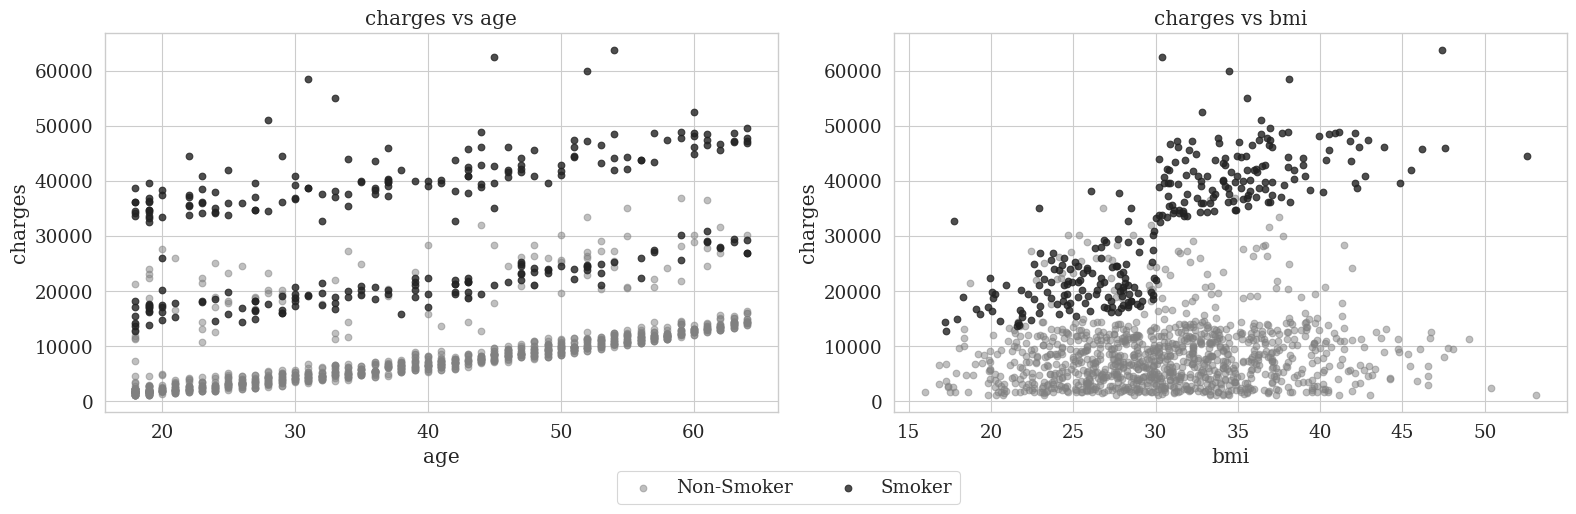

In [54]:
# Smoking, age and bmi should have a high influence on insurance costs --> Check
# Create array for target and predictors
target = 'charges'
predictors = ['age', 'bmi']

# Create a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Create a scatter plot for each predictor
for i, predictor in enumerate(predictors):

    # Plot non-smokers
    axs[i].scatter(insurance_data_final[insurance_data_final['smoker_yes'] == 0][predictor],
                   insurance_data_final[insurance_data_final['smoker_yes'] == 0][target],
                   alpha=0.5, color='gray', label='Non-Smoker' if i == 0 else "")

    # Plot smokers
    axs[i].scatter(insurance_data_final[insurance_data_final['smoker_yes'] == 1][predictor],
                   insurance_data_final[insurance_data_final['smoker_yes'] == 1][target],
                   alpha=0.8, color='#222222', label='Smoker' if i == 0 else "")

    # Adjust title and axis
    axs[i].set_title(f'{target} vs {predictor}')
    axs[i].set_xlabel(predictor)
    axs[i].set_ylabel(target)

# Add a legend to the figure, centered at the bottom
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

# Adjust layout for better spacing
plt.tight_layout()

# Show plot
plt.show()

In [55]:
# For formular specification in statsmodel feature vectors can not be used. Therefore intercept is added to training set
train_set = sm.add_constant(train_set)

# Describe regression formular with interaction
formula = 'charges ~ age + children + bmi + sex_male + bmi30*smoker_yes + age*smoker_yes + smoker_yes'

# Create Gamma Regression model with log-link function and formular
gamma_model2 = sm.GLM.from_formula(formula=formula, data=train_set, family=sm.families.Gamma(link=sm.families.links.Log()))

# Fit model and print summary
gamma_results_2 = gamma_model2.fit()
print(gamma_results_2.summary2())

               Results: Generalized linear model
Model:               GLM              AIC:            18626.0688
Link Function:       Log              BIC:            -6124.1996
Dependent Variable:  charges          Log-Likelihood: -9304.0   
Date:                2024-02-11 14:15 LL-Null:        -9856.7   
No. Observations:    935              Deviance:       210.15    
Df Model:            8                Pearson chi2:   440.      
Df Residuals:        926              Scale:          0.47489   
Method:              IRLS                                       
----------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept         7.4334   0.1783 41.6883 0.0000  7.0839  7.7829
age               0.0330   0.0018 17.9672 0.0000  0.0294  0.0366
children          0.0960   0.0189  5.0735 0.0000  0.0589  0.1331
bmi               0.0053   0.0063  0.8397

In [56]:
# Calculate influence measures
influence_glm = gamma_results_2.get_influence()

# Obtain summary measures of influence
summaries = influence_glm.summary_frame()

# Extract Cook's Distances
cooks_d_glm = summaries['cooks_d']

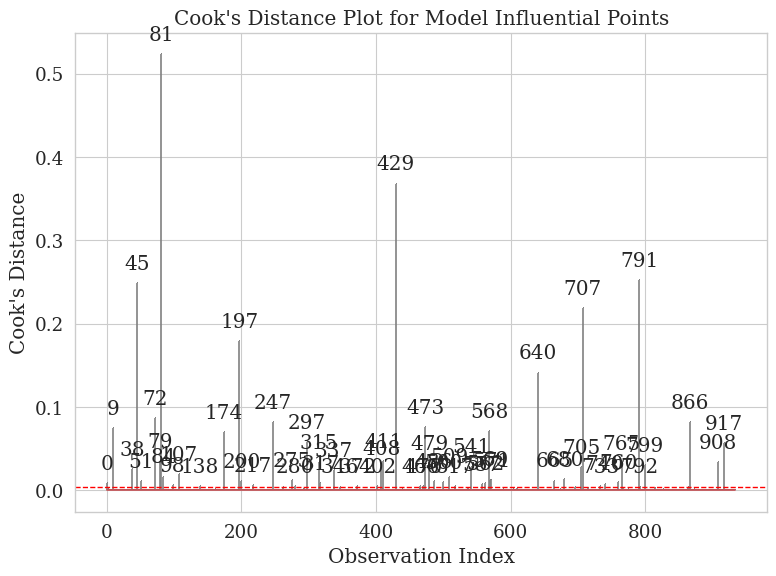

In [57]:
# Take a threshold of 4/N
threshold = 4/len(X_train)

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.stem(np.arange(len(cooks_d_glm)), cooks_d_glm, markerfmt=',', use_line_collection=True, linefmt='gray')

# Setting the title and labels
ax.set_title('Cook\'s Distance Plot for Model Influential Points')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Cook\'s Distance')

# Adding a horizontal line for the Cook's distance threshold
ax.axhline(y=threshold, ls='--', c='red', linewidth=1)

# Adding grid lines
ax.grid(True)

# Annotate the points above the threshold
for i, cd in enumerate(cooks_d_glm):
    if cd > threshold:
        ax.annotate(f"{i}", (i, cd), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [58]:
# Identify all points where Cook's distance is above the threshold
influential_points = cooks_d_glm > threshold

# Create an array of indices for influential points
influential_indices = np.where(influential_points)[0]

size_before = len(train_set)

train_set.reset_index(drop=True, inplace=True)

# Now try to drop the rows by index
train_set = train_set.drop(index=influential_indices)

print("Removed Outliers:", size_before-len(train_set))

Removed Outliers: 58


In [59]:
# Refit model to check for improvements
gamma_model = sm.GLM.from_formula(formula=formula, data=train_set, family=sm.families.Gamma(link=sm.families.links.Log()))
gamma_results = gamma_model.fit()

# Print summary
print(gamma_results.summary2())

                Results: Generalized linear model
Model:                GLM              AIC:            15408.1504
Link Function:        Log              BIC:            -5854.5533
Dependent Variable:   charges          Log-Likelihood: -7695.1   
Date:                 2024-02-11 14:15 LL-Null:        -16368.   
No. Observations:     877              Deviance:       27.455    
Df Model:             8                Pearson chi2:   34.1      
Df Residuals:         868              Scale:          0.039322  
Method:               IRLS                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         6.7348   0.0526 128.1351 0.0000  6.6318  6.8378
age               0.0458   0.0006  83.0011 0.0000  0.0447  0.0469
children          0.1094   0.0056  19.6131 0.0000  0.0985  0.1203
bmi               0.0033  

In [60]:
# Define the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Lists to store the results from each fold
mse_list = []
mae_list = []
rmse_list = []

# Perform 5-fold Cross-Validation
for train_index, test_index in kf.split(train_set):

    # Split into the training and testing data for fold
    train_set_fold = train_set.iloc[train_index]
    test_set_fold = train_set.iloc[test_index]

    # Create Gamma Regression model with formular and traing with fold training data
    gamma_model = sm.GLM.from_formula(formula=formula, data=train_set_fold, family=sm.families.Gamma(link=sm.families.links.Log()))
    # Fit the model
    gamma_results = gamma_model.fit()

    # Predict on the test set
    y_pred_fold = gamma_results.predict(test_set_fold)
    y_test_fold = test_set_fold["charges"]

    # Calculate the mean squared error for the fold
    mse = mean_squared_error(y_pred_fold, y_test_fold)
    mae = mean_absolute_error(y_pred_fold, y_test_fold)
    rmse = np.sqrt(mse)

    # Append to corresponding list
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)

# Print mean of performance metric fold list
print("MSE Cross-Validation:", np.mean(mse_list))
print("RMSE Cross-Validation:", np.mean(rmse_list))
print("MAE Cross-Validation:", np.mean(mae_list))

MSE Cross-Validation: 9607500.83864246
RMSE Cross-Validation: 3081.804298397299
MAE Cross-Validation: 1606.0753441087422


In [61]:
# Refit the model with complete training set
gamma_model = sm.GLM.from_formula(formula=formula, data=train_set, family=sm.families.Gamma(link=sm.families.links.Log()))
gamma_results = gamma_model.fit()

# Ensure that test_set has constant for intercept term
test_set = sm.add_constant(test_set)

# Make predictions with gamma model
y_pred_gamma = gamma_results.predict(test_set)

# Calculate performance metrics
mse_gamma = mean_squared_error(y_test, y_pred_gamma)
rmse_gamma = np.sqrt(mse_gamma)
mae_gamma = mean_absolute_error(y_test, y_pred_gamma)

# Print performance metrics
print(f"MSE  Prediction: {mse_gamma}")
print(f"RMSE Prediction: {rmse_gamma}")
print(f"MAE  Prediction: {mae_gamma}")

MSE  Prediction: 21805704.049810942
RMSE Prediction: 4669.657808641972
MAE  Prediction: 2177.0192926846535


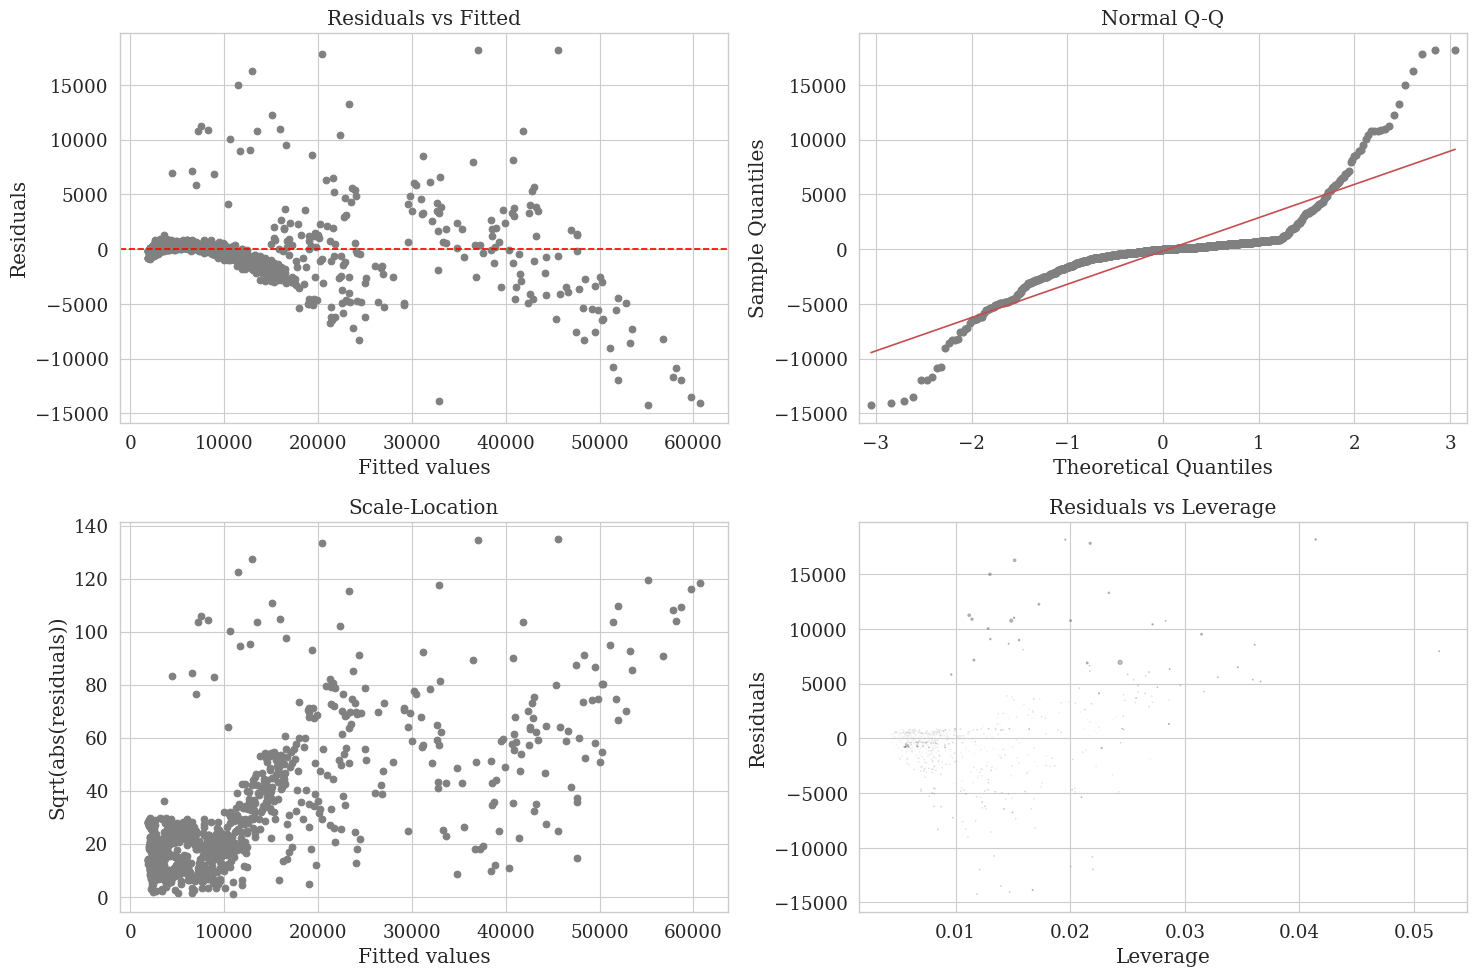

In [62]:
# Create diagnostic plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Residuals vs Fitted
axs[0, 0].scatter(gamma_results.fittedvalues, gamma_results.resid_response, color = "gray")
axs[0, 0].axhline(0, color='red', linestyle='--')
axs[0, 0].set_title('Residuals vs Fitted')
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')

# Normal Q-Q
sm.qqplot(gamma_results.resid_response, line='s', ax=axs[0, 1], markeredgecolor='gray', markerfacecolor='gray')
axs[0, 1].set_title('Normal Q-Q')

# Scale-Location
axs[1, 0].scatter(gamma_results.fittedvalues, np.sqrt(np.abs(gamma_results.resid_response)), color = "gray")
axs[1, 0].set_title('Scale-Location')
axs[1, 0].set_xlabel('Fitted values')
axs[1, 0].set_ylabel('Sqrt(abs(residuals))')

# Residuals vs Leverage
# We will use the cooks distance as a measure for the leverage plot
influence = gamma_results.get_influence()
cooks = influence.cooks_distance[0]
leverage = influence.hat_matrix_diag
axs[1, 1].scatter(leverage, gamma_results.resid_response, s=50 * cooks, alpha=0.5, color = "gray")
axs[1, 1].set_title('Residuals vs Leverage')
axs[1, 1].set_xlabel('Leverage')
axs[1, 1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

# 03 Modelling, Cross Validation and Prediction - Random Forest




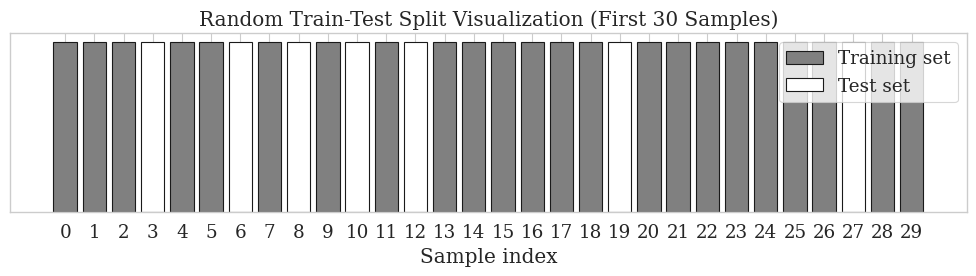

((935, 12), (402, 12), (935,), (402,))

In [29]:
# Create identical training and test set. This is necessary as both set were adjust in the GLM modelling process
train_set, test_set = train_set, test_set = plot_train_test_split(insurance_data_final, test_size=0.3, max_samples=30)

# Reset indeces of training and test set
train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Create target and feature vector for training set
X_train = train_set.drop(["charges"], axis = 1)
y_train = train_set["charges"]

# Create target and feature vector for test set
X_test = test_set.drop(["charges"], axis = 1)
y_test = test_set["charges"]

# Display the dimensions of the train and test sets
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [30]:
# Fit a base model using standard settings for hyperparameters
rf_basemodel = RandomForestRegressor(random_state=42)
rf_basemodel.fit(X_train, y_train)

# Make first predictions
y_pred_rf = rf_basemodel.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_rf)

# Print performance metrics
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 22138044.426
Mean RMSE: 4705.108
Mean MAE: 2752.091


In [31]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10, 15, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10, 15, 20],
 'min_samples_leaf': [2, 5, 10, 15, 20],
 'bootstrap': [True, False]}

In [32]:
# Create RandomizedSearchCV with basemodel, defined parameter grid and use 5-fold Cross-Validation
# "n_iter" represents the number of iterations to find best hyperparameters. Will be set to 100 due to time limitations
rf_random = RandomizedSearchCV(estimator = rf_basemodel, param_distributions = random_grid, n_iter = 100, cv = 5,
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 1, 2,
                                                         3, 4, 5, 6, 7, 8, 9,
                                                         10, 11],
                                        'min_samples_leaf': [2, 5, 10, 15, 20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [33]:
# Display best parameters found by RandomizedSearchCV
print(rf_random.best_params_)

{'n_estimators': 1200, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 8, 'max_depth': 90, 'bootstrap': False}


In [34]:
# Based on the results of the RandomizedSearchCV, the parameter space could be reduced to a range of candidates for best hyperparameters
# Parameter grid for GridSearchCV is based on results of the RandomizedSearchCV. Ranges for the different hyperparameters were adjusted around the best parameters found by the RandomizedSearchCV

# Define the parameter grid to search
param_grid = {'n_estimators': [1100, 1150, 1200, 1250, 1300],
               'max_features': [7,8,9],
               'max_depth': [85, 90, 95],
               'min_samples_split': [13, 15, 17],
               'min_samples_leaf': [13, 15, 17],
               'bootstrap': [False]}

# Create the base model to tune
rf = RandomForestRegressor(random_state=42)

# Define scoring function using MSE as criterion
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create RandomizedSearchCV with basemodel, defined parameter grid and cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring=scorer, verbose=2)

# Fit grid search to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [85, 90, 95],
                         'max_features': [7, 8, 9],
                         'min_samples_leaf': [13, 15, 17],
                         'min_samples_split': [13, 15, 17],
                         'n_estimators': [1100, 1150, 1200, 1250, 1300]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=2)

In [35]:
# Print best parameters found
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'bootstrap': False, 'max_depth': 85, 'max_features': 8, 'min_samples_leaf': 15, 'min_samples_split': 13, 'n_estimators': 1100}


In [36]:
#Specify best model according to grid search results
rf_best = RandomForestRegressor(
    random_state=42,
    n_estimators=1100,
    bootstrap = True,
    min_samples_leaf = 15,
    min_samples_split = 13,
    max_features = 8,
    max_depth = 85
)

In [37]:
#Define the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Lists to store the results from each fold
mse_list = []
mae_list = []
rmse_list = []

# Loop over each fold
for train_index, test_index in kf.split(X_train):
    # Split into the training and testing data
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model
    rf_best.fit(X_train_fold, y_train_fold)

    # Predict on the test set
    y_pred_fold = rf_best.predict(X_test_fold)

    # Calculate the mean squared error for the fold
    mse = mean_squared_error(y_pred_fold, y_test_fold)
    mae = mean_absolute_error(y_pred_fold, y_test_fold)
    rmse = np.sqrt(mse)

    # Append performance metrics to fold list
    mse_list.append(mse)
    mae_list.append(mae)
    rmse_list.append(rmse)

#Print results
print("MSE per Fold:", mse_list)
print("RMSE per Fold:", rmse_list)
print("MAE per Fold:", mae_list)

MSE per Fold: [21962013.681890305, 14788758.959993929, 27011748.006139442, 21697017.911091816, 21519233.740268223]
RMSE per Fold: [4686.364655240809, 3845.6155502070055, 5197.282752183052, 4658.00578693198, 4638.882811655003]
MAE per Fold: [2722.3658180600323, 2424.703616369455, 2847.6795917058334, 2836.536107011919, 2748.6711300123543]


In [38]:
# Print the results
print(f"Mean MSE: {np.mean(mse_list):.3f}")
print(f"Mean RMSE: {np.mean(rmse_list):.3f}")
print(f"Mean MAE: {np.mean(mae_list):.3f}")

Mean MSE: 21395754.460
Mean RMSE: 4605.230
Mean MAE: 2715.991


In [39]:
#Specify best model according to grid search results
rf_best = RandomForestRegressor(
    random_state=42,
    n_estimators=1100,
    bootstrap = True,
    min_samples_leaf = 15,
    min_samples_split = 13,
    max_features = 8,
    max_depth = 85
)

rf_best.fit(X_train, y_train)

# Make final predictions
y_pred_RF = rf_best.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred_RF)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_RF)

# Print the results
print(f"Mean MSE: {mse:.3f}")
print(f"Mean RMSE: {rmse:.3f}")
print(f"Mean MAE: {mae:.3f}")

Mean MSE: 18644283.460
Mean RMSE: 4317.903
Mean MAE: 2485.728


# 04 Comparison of results

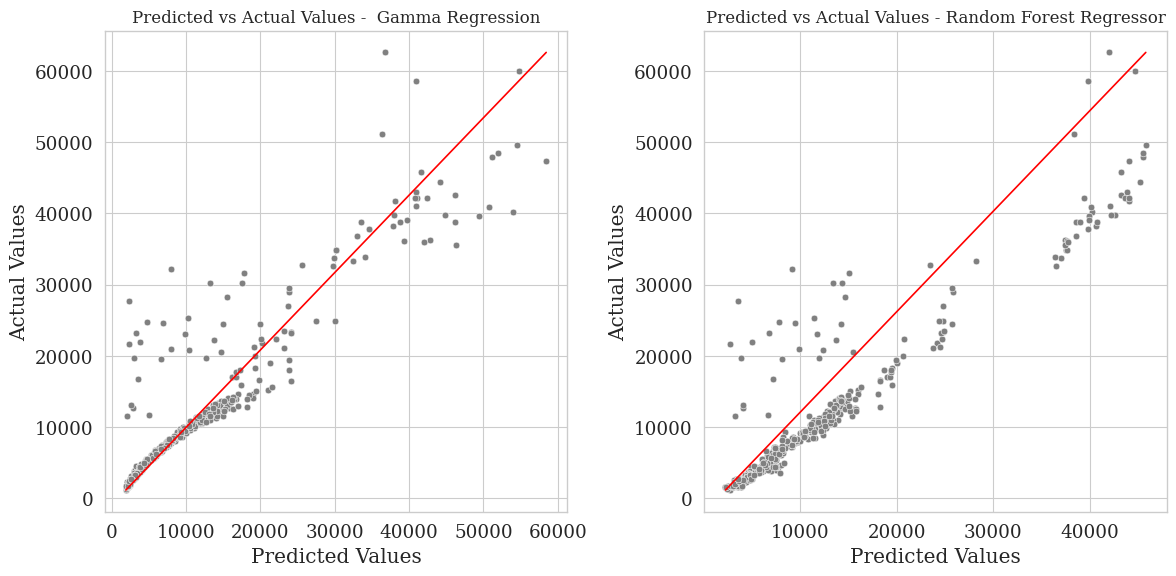

In [45]:
# Initialize pyplot figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Create Actuals vs. Predictions Scatterplot for predictions made by Random Forest
sns.scatterplot(x=y_pred_RF, y=y_test, ax=axs[1], color="gray")
# Optical adjustments (X/Y-Lables, Title, Line of perfect prediction)
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_title('Predicted vs Actual Values - Random Forest Regressor', fontsize=12)
axs[1].plot([min(y_pred_RF), max(y_pred_RF)], [min(y_test), max(y_test)], color='red')  # line of perfect prediction
axs[1].grid(True)

# Create Actuals vs. Predictions Scatterplot for predictions made by GLM
sns.scatterplot(x=y_pred_gamma, y=y_test, ax=axs[0], color="gray")
# Optical adjustments (X/Y-Lables, Title, Line of perfect prediction)
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Actual Values')
axs[0].set_title('Predicted vs Actual Values -  Gamma Regression', fontsize=12)
axs[0].plot([min(y_pred_gamma), max(y_pred_gamma)], [min(y_test), max(y_test)], color='red')  # line of perfect prediction
axs[0].grid(True)

# Adjust the layout
plt.tight_layout()

# Show plot
plt.show()

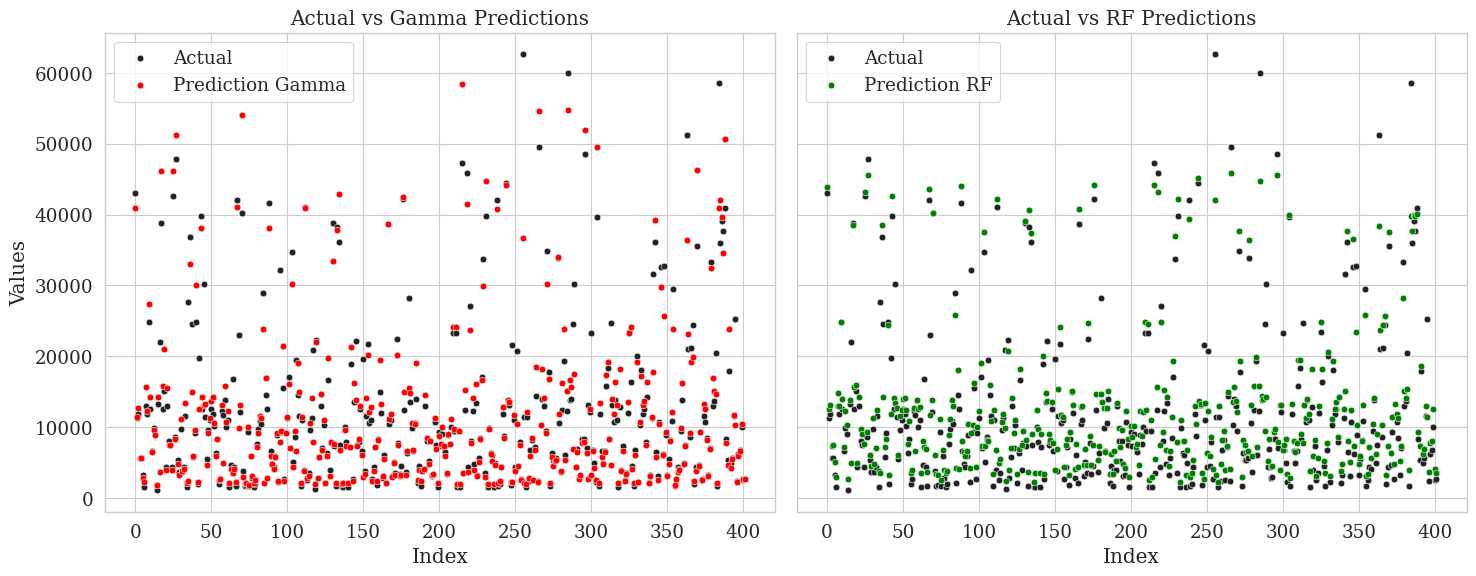

In [48]:
# Convert predictions and actuals to pandas Series
y_pred_gamma_series = pd.Series(y_pred_gamma, name='Prediction GLM')
y_pred_rf_series = pd.Series(y_pred_RF, name='Prediction RF')
y_test_series = pd.Series(y_test, name='Actual')

# Create a DataFrame
predictions_df = pd.concat([y_test_series, y_pred_gamma_series, y_pred_rf_series], axis=1)

# Sort DataFrame by index
predictions_df.sort_index(inplace=True)

# Initialize pyplot figure with 2 subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Plot for GLM predictions
sns.scatterplot(ax=axs[0], data=predictions_df, x=predictions_df.index, y='Actual', label='Actual', color='#222222', marker='o')
sns.scatterplot(ax=axs[0], data=predictions_df, x=predictions_df.index, y='Prediction GLM', label='Prediction Gamma', color='red', marker = 'o')
axs[0].set_title('Actual vs Gamma Predictions')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Values')
axs[0].legend()
axs[0].grid(True)

# Plot for RF predictions
sns.scatterplot(ax=axs[1], data=predictions_df, x=predictions_df.index, y='Actual', label='Actual', color='#222222', marker='o')
sns.scatterplot(ax=axs[1], data=predictions_df, x=predictions_df.index, y='Prediction RF', label='Prediction RF', color='green', marker = 'o')
axs[1].set_title('Actual vs RF Predictions')
axs[1].set_xlabel('Index')
axs[1].legend()
axs[1].grid(True)

# Display the plot
plt.tight_layout()
plt.show()

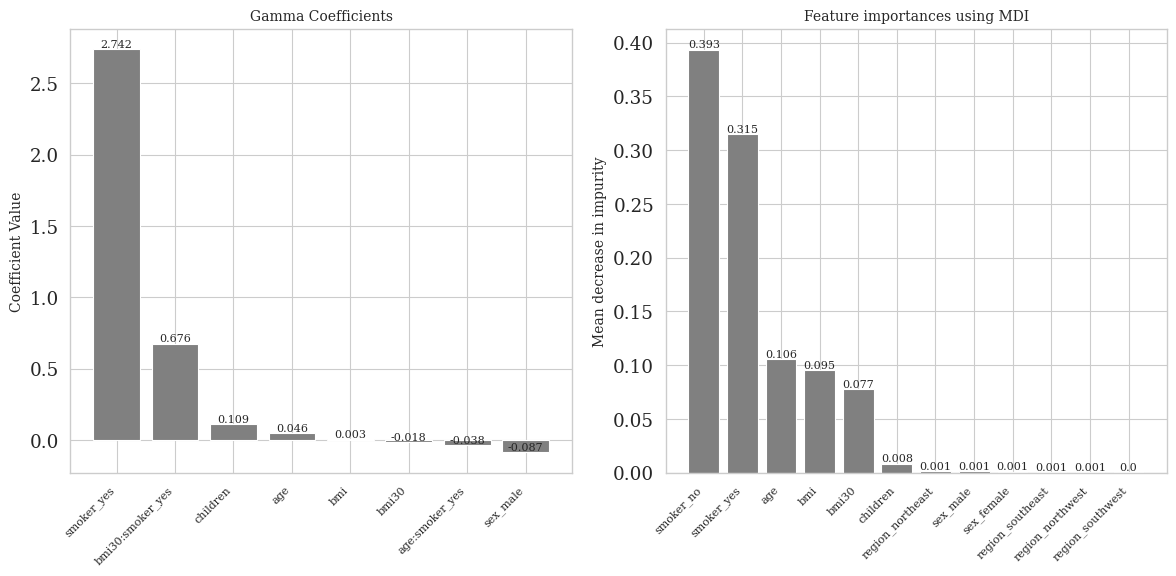

In [50]:
# Get feature importances from Random Forest
importances = rf_best.feature_importances_

# Add importances and corresponding column names to a dataframe
forest_importances = pd.Series(importances, X_train.columns).sort_values(ascending=False)

# Get coefficients from Negative Binomial model
gamma_coefficients = gamma_results.params[1:]  # Exclude intercept
gamma_coefficients = pd.Series(gamma_coefficients, index=gamma_results.model.exog_names[1:]).sort_values(ascending=False)

# Initialize pyplot figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Random Forest feature importances
bars_rf = axs[1].bar(forest_importances.index, forest_importances, color = "gray")
axs[1].set_title("Feature importances using MDI", fontsize=10)
axs[1].set_ylabel("Mean decrease in impurity", fontsize=10)
axs[1].set_xticklabels(forest_importances.index, rotation = 45, ha="right", fontsize=8)


# Add the actual numbers on top of each bar, centered (Random Forest)
for bar in bars_rf:
    yval = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center', fontsize=8)

# Plot Negative Binomial coefficients
bars_nb = axs[0].bar(gamma_coefficients.index, gamma_coefficients, color = "gray")
axs[0].set_title("Gamma Coefficients", fontsize=10)
axs[0].set_ylabel("Coefficient Value", fontsize=10)
axs[0].set_xticklabels(gamma_coefficients.index, rotation = 45, ha="right", fontsize=8)

# Add the actual numbers on top of each bar, centered (Negative Binomial)
for bar in bars_nb:
    yval = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 3), va='bottom', ha='center', fontsize=8)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()